In [1]:
from model import Network
from data import load_cifar100_dataloaders, WhiteningTransformation
import torch
import torchvision.transforms as transforms
import torch.nn as nn
from criterion import ReconstructImageFromFCLoss
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from metrics import lpips_gpu, psnr

# reproducibility
random_seed = 2024

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)

In [2]:
# load to model
model_config = './model_config/fc1_cocktail_party_cifar100_instance.json'
checkpoint_path = './checkpoints/010224_fc1_cocktail_party_cifar100_pretraining_wout_bias_wout_normalization.pth'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Network(model_config)
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['state_dict'])
model = model.to(device)

# get val loader
batch_size = 64
data_path = './data'
transform = transforms.Compose([
    transforms.ToTensor(),
])

_, val_dataloader = load_cifar100_dataloaders(data_path, batch_size, transform)
selected_val_batch_data, selected_val_batch_label = next(iter(val_dataloader))
selected_val_batch_data = selected_val_batch_data.to(device)
selected_val_batch_label = selected_val_batch_label.to(device)

Files already downloaded and verified
Files already downloaded and verified


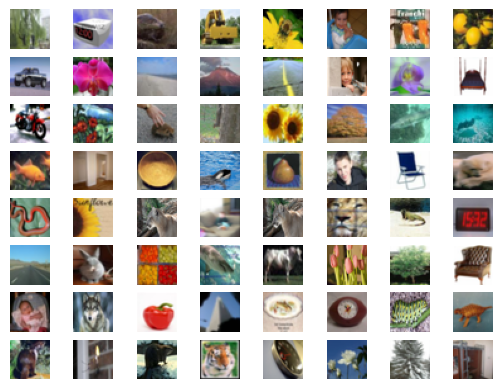

In [3]:
with torch.no_grad():
    fig, axes = plt.subplots(8, 8)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()

In [4]:
# receiving gradients
model.zero_grad()
criterion = nn.CrossEntropyLoss()
output = model(selected_val_batch_data.reshape(batch_size, -1))
loss = criterion(output, selected_val_batch_label)
loss.backward()
gradient_of_layers = []
for param in model.parameters():
    gradient_of_layers.append(param.grad.data.clone().to('cpu'))
print([x.size() for x in gradient_of_layers])

[torch.Size([100, 3072])]


In [5]:
whitening_transform = WhiteningTransformation()
whitened_gradient = torch.from_numpy(whitening_transform.transform(gradient_of_layers[0].detach().numpy().T)).to(torch.float32).T
whitened_gradient = whitened_gradient.to(device)

In [6]:
# criterion output testing
unmixing_matrix = torch.rand((selected_val_batch_data.size(0), gradient_of_layers[0].size(0)), requires_grad=True, device=device)
reconstruction_loss = ReconstructImageFromFCLoss(32, 32, 3, 0.5268346884538906, 7.415861546208221, 4.910887792883931)
optimizer = torch.optim.Adam([unmixing_matrix])

for iter_idx in range(25000):
    optimizer.zero_grad()
    # out_score, non_gaussianity_score, total_variance_score, mutual_independence_score
    loss, _, _, _ = reconstruction_loss(unmixing_matrix, whitened_gradient)
    loss.backward()
    optimizer.step()
    
    if (iter_idx + 1) % 1000 == 0 or iter_idx == 0:
        print('loss: {}'.format(loss.item()))

loss: 8.921873092651367
loss: 5.1010212898254395
loss: 4.939939975738525
loss: 4.935885906219482
loss: 4.933933734893799
loss: 4.933084964752197
loss: 4.9333014488220215
loss: 4.932895660400391
loss: 4.933084487915039
loss: 4.933038234710693
loss: 4.932848930358887
loss: 4.932843208312988
loss: 4.932398796081543
loss: 4.932719707489014
loss: 4.932643890380859
loss: 4.932799339294434
loss: 4.932499408721924
loss: 4.932685375213623
loss: 4.93226957321167
loss: 4.932446002960205
loss: 4.93232536315918
loss: 4.932963848114014
loss: 4.932522296905518
loss: 4.932401657104492
loss: 4.932461261749268
loss: 4.9327239990234375


In [7]:
unmixing_matrix = unmixing_matrix.detach().to('cpu')
whitened_gradient = whitened_gradient.detach().to('cpu')

## PSNR Values

In [8]:
with torch.no_grad():
    psnr_match, psnr_is_positive, mean_psnr = psnr(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [9]:
psnr_match

[tensor([19, 49]),
 tensor([63, 32]),
 tensor([ 6, 37]),
 tensor([53, 34]),
 tensor([32, 21]),
 tensor([50, 54]),
 tensor([15, 36]),
 tensor([40, 12]),
 tensor([51, 43]),
 tensor([44, 25]),
 tensor([52, 18]),
 tensor([18,  8]),
 tensor([57, 14]),
 tensor([11,  0]),
 tensor([20, 27]),
 tensor([23, 59]),
 tensor([35, 57]),
 tensor([38, 60]),
 tensor([36, 22]),
 tensor([29,  6]),
 tensor([ 5, 55]),
 tensor([ 3, 45]),
 tensor([21,  1]),
 tensor([0, 3]),
 tensor([45, 31]),
 tensor([27, 17]),
 tensor([22, 19]),
 tensor([42, 13]),
 tensor([39, 61]),
 tensor([61, 48]),
 tensor([33, 29]),
 tensor([24,  9]),
 tensor([41, 26]),
 tensor([10, 40]),
 tensor([55, 11]),
 tensor([ 4, 46]),
 tensor([43, 24]),
 tensor([46, 63]),
 tensor([60, 33]),
 tensor([54, 20]),
 tensor([17, 53]),
 tensor([ 8, 62]),
 tensor([31, 23]),
 tensor([1, 5]),
 tensor([16, 16]),
 tensor([62, 28]),
 tensor([ 7, 56]),
 tensor([30, 42]),
 tensor([2, 7]),
 tensor([49, 47]),
 tensor([12, 39]),
 tensor([13, 58]),
 tensor([26, 38]),

In [10]:
mean_psnr

9.58503783494234

In [11]:
psnr_is_positive

[False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False]

## LPIPS

In [12]:
with torch.no_grad():
    lpips_match, lpips_is_positive, mean_lpips = lpips_gpu(unmixing_matrix @ whitened_gradient, selected_val_batch_data.detach().to('cpu'), return_matches=True)

In [13]:
lpips_match

[tensor([48, 55]),
 tensor([43, 59]),
 tensor([7, 9]),
 tensor([54, 56]),
 tensor([20, 16]),
 tensor([47, 13]),
 tensor([53, 32]),
 tensor([15, 49]),
 tensor([45, 17]),
 tensor([56, 34]),
 tensor([42, 43]),
 tensor([52, 36]),
 tensor([ 3, 37]),
 tensor([58, 22]),
 tensor([ 2, 29]),
 tensor([57, 54]),
 tensor([24, 47]),
 tensor([10,  3]),
 tensor([62, 38]),
 tensor([29,  8]),
 tensor([26, 35]),
 tensor([37, 48]),
 tensor([36,  5]),
 tensor([31,  6]),
 tensor([63, 46]),
 tensor([60, 14]),
 tensor([46, 61]),
 tensor([35, 63]),
 tensor([ 9, 30]),
 tensor([25, 23]),
 tensor([30, 18]),
 tensor([18, 58]),
 tensor([23,  0]),
 tensor([11, 11]),
 tensor([44, 19]),
 tensor([ 0, 52]),
 tensor([34, 44]),
 tensor([13, 15]),
 tensor([59, 21]),
 tensor([27, 45]),
 tensor([49,  1]),
 tensor([12, 12]),
 tensor([32, 62]),
 tensor([50,  2]),
 tensor([17, 24]),
 tensor([ 6, 57]),
 tensor([ 4, 41]),
 tensor([51, 31]),
 tensor([41, 27]),
 tensor([14, 39]),
 tensor([39, 42]),
 tensor([40,  7]),
 tensor([61,  

In [14]:
mean_lpips

0.1899149824748747

In [15]:
lpips_is_positive

[False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True]

## Estimated images

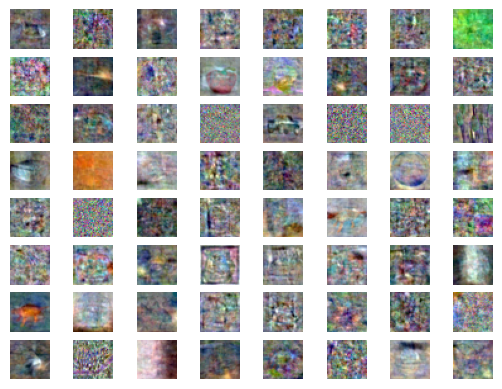

In [16]:
with torch.no_grad():
    estimated_img = (unmixing_matrix @ whitened_gradient)
    
    fig, axes = plt.subplots(8, 8)
    
    for estimate_idx, (estimate, ax) in enumerate(zip(estimated_img, axes.flatten())):
        estimate_coeff = 1 if lpips_is_positive[lpips_match[estimate_idx][0].item()] else -1
        img = colors.Normalize()(np.asarray(estimate_coeff * estimate).reshape(3, 32, 32).transpose(1, 2, 0))
        ax.imshow(img)
        ax.axis('off')
    plt.show()

## Original images

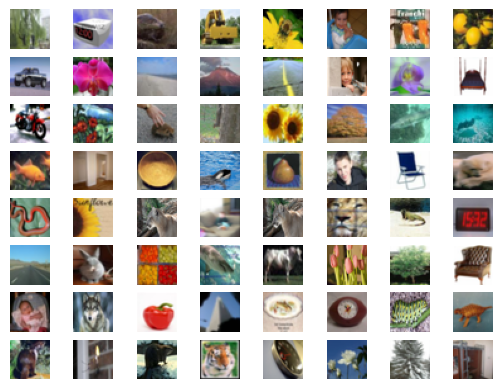

In [19]:
with torch.no_grad():
    fig, axes = plt.subplots(8, 8)
    
    for estimate, ax in zip(selected_val_batch_data, axes.flatten()):
        img = transforms.ToPILImage()(estimate.reshape(3, 32, 32))
        img = np.asarray(img)
        ax.imshow(img)
        ax.axis('off')
    plt.show()